## 0. Import Libraries

In [31]:
from glob import glob
from metpy.units import units
from shapely.geometry import mapping
from matplotlib.patches import Patch
from cartopy.feature import ShapelyFeature

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import geopandas as gpd
import seaborn as sns
import cartopy.io.shapereader as shpreader 

import rioxarray
import cartopy
import matplotlib
import proplot

## 1. Parameters

In [3]:
# general path
path_general = 'data'

## 2. Open Data

In [4]:
data_lu = rioxarray.open_rasterio(fr'{path_general}/land_use_data.tiff').squeeze()

In [5]:
data_lu.rio.crs

CRS.from_epsg(4326)

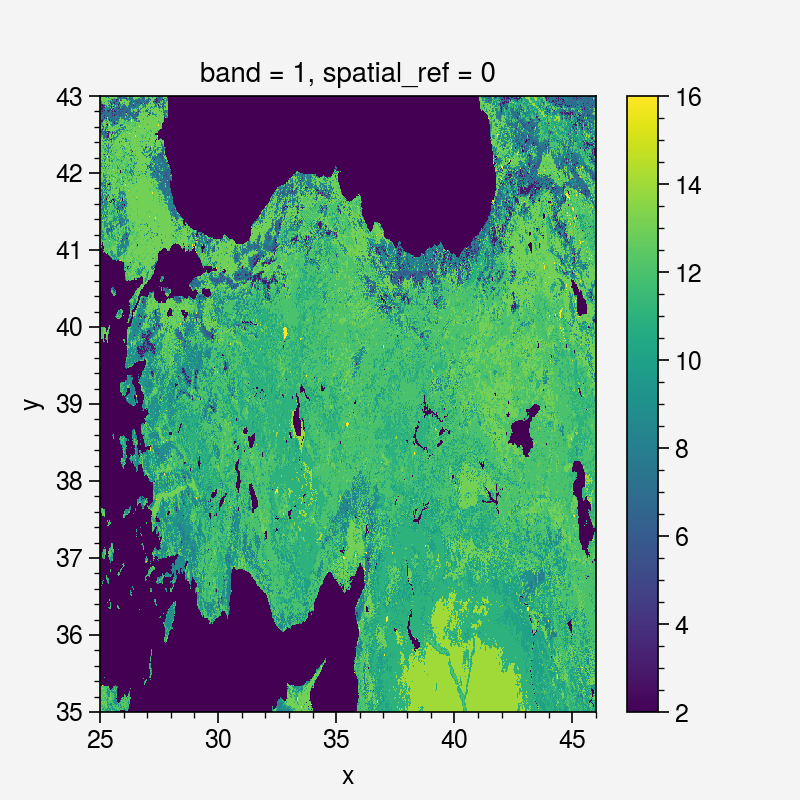

In [6]:
data_lu.plot()

## 3. Clip to Turkey

In [7]:
def clip_to_city(data, shapefile):
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [28]:
path_shape = fr'{path_general}/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_tr = gpd.read_file(path_shape)

In [13]:
data_lu_tr = clip_to_city(data_lu, shape_tr)

# change 0 to np.nan
data_lu_tr = data_lu_tr.where(data_lu_tr != 0, np.nan)

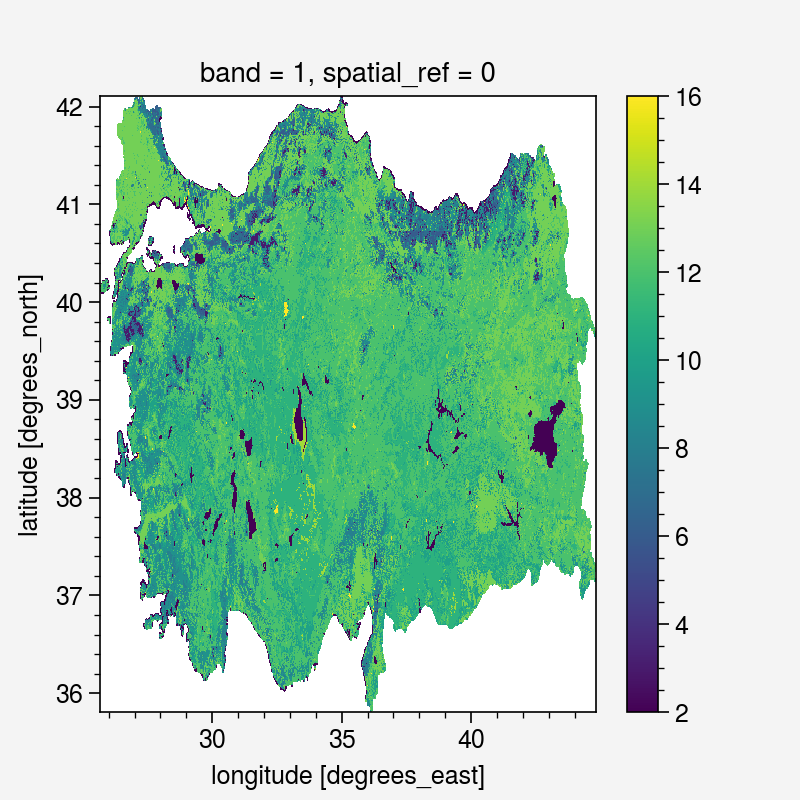

In [14]:
data_lu_tr.plot()

## 4. Land Use Graphic

### 4.1 Options

In [44]:
cb_list = [
    '#9be3ff',
    '#009200',
    '#00b900',
    '#006900',
    '#009d86',
    '#70cdc0',
    '#c8bb27',
    '#929292',
    '#797100',
    '#b3b098',
    '#fcee81',
    '#f00',
]

labels = ['water', 'Evergreen Needleleaf Forest',
       'Deciduous Broadleaf Forest', 'Mixed Forest', 'Woodland',
       'Wooded Grassland', 'Closed Shrubland', 'Open Shrubland',
       'Grassland', 'Cropland', 'Bare Ground', 'Urban and Built-up']

# make a color map of fixed colors
cmap = matplotlib.colors.ListedColormap(cb_list)
unique = np.unique(data_lu_tr)
unique = unique[~np.isnan(unique)]
bounds= np.concatenate([np.array([0]), unique,])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N,)

In [43]:
l = np.unique(data_lu_tr)
l[~np.isnan(l)]

array([ 2.,  3.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 16.])

In [54]:
# Parameters to change (plot) -------------------
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(central_longitude=35.0,
                                   central_latitude=39.0,
                                   globe=globe)

# fig features
fig_array = [[1, 1],
            ]
graphic_no = 1

In [39]:
data_lu_tr

<xarray.DataArray (y: 756, x: 2299)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 42.1 42.1 42.09 42.08 ... 35.84 35.83 35.82 35.81
  * x            (x) float64 25.67 25.68 25.69 25.7 ... 44.8 44.8 44.81 44.82
    band         int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### 4.2 Plot

/tmp/ipykernel_1863/1604951002.py:2: ProplotWarning: Ignoring unused projection-specific format() keyword argument(s): {'aspect': 10}
  fig, axs = proplot.subplots(fig_array,


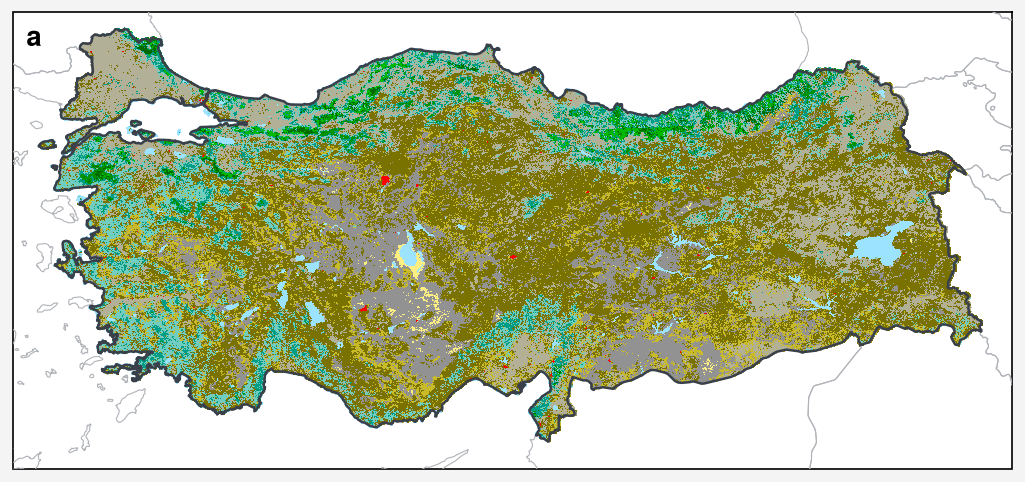

In [70]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=10,
                            axwidth=5,
                            proj=[lcc],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.50,
                            wspace=0.4,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc=True,
           zorder=50)

# ankara limits d01
axs.format(lonlim=(25.8, 45.1), 
           latlim=(35., 42.2), 
           longrid=False, 
           latgrid = False)

# shapefile
# External complementary shapefiles
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
cts = ['Syria', 'Iraq', 'Iran',
       'Azerbaijan', 'Armenia',
       'Russia', 'Georgia', 'Bulgaria',
       'Greece', 'Cyprus', 'Northern Cyprus']
    
# add external shapefile geometries
for country in shpreader.Reader(shpfilename).records():
    
    if country.attributes['ADMIN'] in cts:
        
        count_shp = country.geometry
        for i in range(1):
            axs.add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='none', edgecolor = '#b0b3b8',
                              linewidth = 0.4, zorder = 21,)
            
    elif country.attributes['ADMIN'] == 'Turkey':
        count_shp = country.geometry
        for i in range(1):
            axs.add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='none', edgecolor = '#3a404a',
                              linewidth = 0.9, zorder = 22,)
            
axs[0].pcolormesh(data_lu_tr['x'].values, data_lu_tr['y'].values,
                      data_lu_tr.values-0.5, cmap=cmap, norm=norm, 
                      transform=cartopy.crs.PlateCarree(), zorder=9)